In [1]:
import boto3
import os
from dotenv import load_dotenv
# Connect to s3
load_dotenv()
 
s3 = boto3.client(
"s3",
aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
region_name=os.getenv("AWS_DEFAULT_REGION")
)

In [2]:
import pandas as pd 

manga_df = pd.read_parquet("../data/cleaned/cleaned_manga_metadata.parquet")

In [3]:
manga_df.head()

,title,tags,popularity,chapters,averageScore,startDate,genres,favourites,meanScore,isAdult,id,volumes,description,has_end_date
0,monster,"[seinen, conspiracy, philosophy, crime, traged...",99352,162.0,91,1994-12-01,"[Drama, Mystery, Psychological, Thriller]",10058,91,False,30001,18.0,Everyone faces uncertainty at some point in th...,1
1,berserk,"[tragedy, seinen, revenge, male protagonist, d...",226590,-1.0,93,1989-08-01,"[Action, Adventure, Drama, Fantasy, Horror, Ps...",36017,93,False,30002,-1.0,"His name is Guts, the Black Swordsman, a feare...",0
2,20th century boys,"[coming of age, ensemble cast, politics, seine...",98859,249.0,88,1999-09-01,"[Drama, Mystery, Psychological, Sci-Fi, Thriller]",7780,88,False,30003,22.0,"Humanity, having faced extinction at the end o...",1
3,yokohama kaidashi kikou,"[iyashikei, female protagonist, post-apocalypt...",34640,144.0,86,1994-04-01,"[Sci-Fi, Slice of Life]",3139,86,False,30004,14.0,Set hundreds of years in the future after an e...,1
4,hajime no ippo: fighting spirit!,"[boxing, shounen, male protagonist, primarily ...",32860,-1.0,87,1989-09-01,"[Action, Comedy, Drama, Sports]",3283,87,False,30007,-1.0,Makunouchi Ippo has been bullied his entire li...,0


<Axes: >

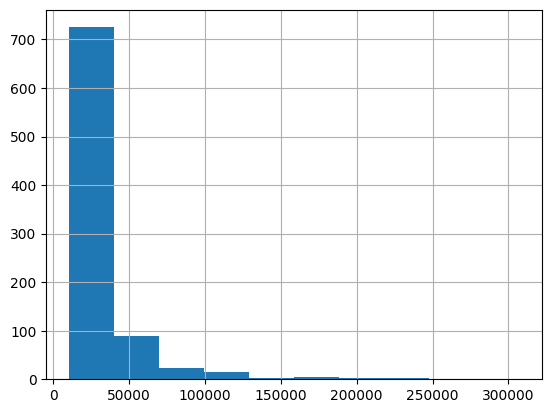

In [4]:
import matplotlib.pyplot as plt

manga_df['popularity'].hist()

<Axes: >

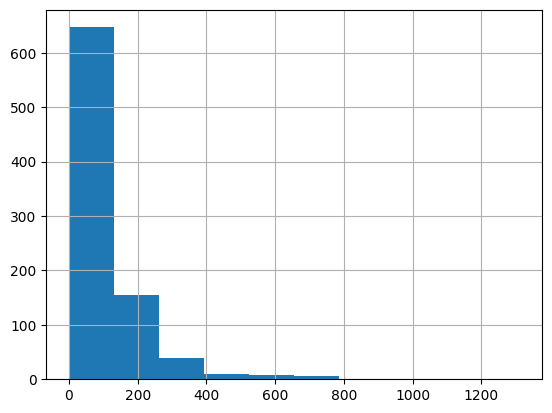

In [5]:
manga_df['chapters'].hist() 

<Axes: >

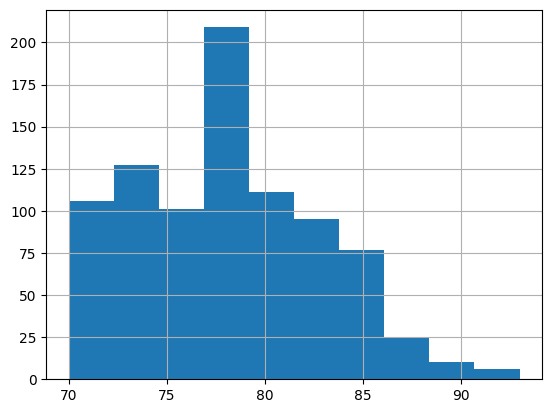

In [6]:
manga_df['averageScore'].hist()

In [7]:
user_df = pd.read_parquet("../data/cleaned/cleaned_user_readdata.parquet")

In [13]:
user_df.head()

,mediaId,userId,progress,progressVolumes,score,priority,private,repeat,status,name
0,30698,1,40,6,3,0,False,0,PAUSED,Josh
1,33500,1,7,1,1,0,False,0,PAUSED,Josh
2,35178,1,6,0,2,0,False,0,PAUSED,Josh
3,31158,1,0,0,0,0,False,0,PLANNING,Josh
4,53390,1,64,10,2,0,False,0,DROPPED,Josh


<Axes: >

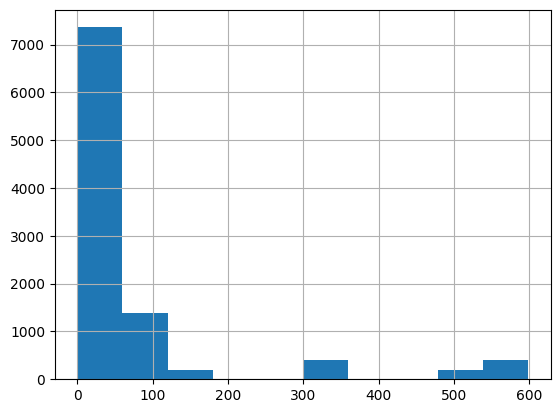

In [15]:
user_df['progress'].hist()

<Axes: >

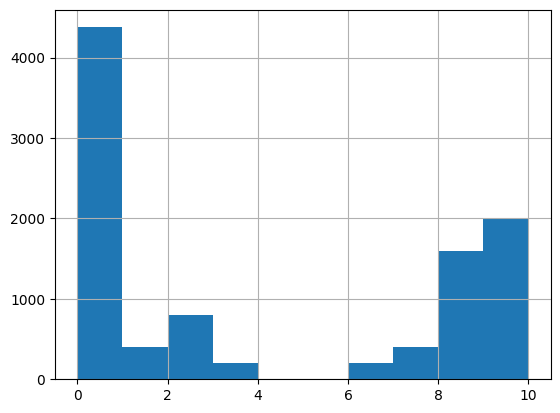

In [16]:
user_df['score'].hist()

In [17]:
user_df['score'].value_counts()

score
0     4378
8     1592
9     1393
2      796
10     597
7      398
1      398
3      199
6      199
Name: count, dtype: int64

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

# Create a working copy for feature engineering
manga_fe = manga_df.copy()

# 1. Parse releaseYear from startDate
manga_fe['releaseYear'] = pd.to_datetime(manga_fe['startDate']).dt.year

# 2. One-hot encode tags
mlb_tags = MultiLabelBinarizer()
tags_encoded = mlb_tags.fit_transform(manga_fe['tags'])
tags_df = pd.DataFrame(tags_encoded, columns=[f'tag_{tag}' for tag in mlb_tags.classes_], index=manga_fe.index)
manga_fe = pd.concat([manga_fe, tags_df], axis=1)

# 3. One-hot encode genres
mlb_genres = MultiLabelBinarizer()
genres_encoded = mlb_genres.fit_transform(manga_fe['genres'])
genres_df = pd.DataFrame(genres_encoded, columns=[f'genre_{genre}' for genre in mlb_genres.classes_], index=manga_fe.index)
manga_fe = pd.concat([manga_fe, genres_df], axis=1)

# 4. Convert isAdult to numeric (already boolean but ensure it's numeric)
manga_fe['isAdult'] = manga_fe['isAdult'].astype(int)

# 5. Log transform popularity, chapters, and favourites
# Add 1 to avoid log(0) issues
manga_fe['popularity_log'] = np.log1p(manga_fe['popularity'])
manga_fe['chapters_log'] = np.log1p(manga_fe['chapters'].replace(-1, 0))  # Replace -1 with 0 before log
manga_fe['favourites_log'] = np.log1p(manga_fe['favourites'])

# 6. Standardize popularity_log, chapters_log, and favourites_log
scaler_numeric = StandardScaler()
numeric_cols_to_scale = ['popularity_log', 'chapters_log', 'favourites_log']
manga_fe[['popularity_log_scaled', 'chapters_log_scaled', 'favourites_log_scaled']] = scaler_numeric.fit_transform(
    manga_fe[numeric_cols_to_scale]
)

# 7. Standardize averageScore
scaler_score = StandardScaler()
manga_fe['averageScore_scaled'] = scaler_score.fit_transform(manga_fe[['averageScore']])

# 8. Drop volumes, meanScore
manga_fe = manga_fe.drop(columns=['volumes', 'meanScore'])

print("Feature engineering complete!")
print(f"\nOriginal columns: {len(manga_df.columns)}")
print(f"New columns: {len(manga_fe.columns)}")
print(f"\nNew columns added:")
print(f"  - releaseYear (parsed from startDate)")
print(f"  - {len(tags_df.columns)} tag encodings")
print(f"  - {len(genres_df.columns)} genre encodings")
print(f"  - popularity_log, chapters_log, favourites_log (log transformed)")
print(f"  - popularity_log_scaled, chapters_log_scaled, favourites_log_scaled (standardized)")
print(f"  - averageScore_scaled (standardized)")
print(f"\nColumns dropped: volumes, meanScore")
print(f"\nFinal shape: {manga_fe.shape}")

Feature engineering complete!

Original columns: 14
New columns: 412

New columns added:
  - releaseYear (parsed from startDate)
  - 373 tag encodings
  - 19 genre encodings
  - popularity_log, chapters_log, favourites_log (log transformed)
  - popularity_log_scaled, chapters_log_scaled, favourites_log_scaled (standardized)
  - averageScore_scaled (standardized)

Columns dropped: volumes, meanScore

Final shape: (867, 412)


In [10]:
manga_fe.columns

Index(['title', 'tags', 'popularity', 'chapters', 'averageScore', 'startDate',
       'genres', 'favourites', 'isAdult', 'id',
       ...
       'genre_Sports', 'genre_Supernatural', 'genre_Thriller',
       'popularity_log', 'chapters_log', 'favourites_log',
       'popularity_log_scaled', 'chapters_log_scaled', 'favourites_log_scaled',
       'averageScore_scaled'],
      dtype='object', length=412)

In [11]:
manga_fe.head()

,title,tags,popularity,chapters,averageScore,startDate,genres,favourites,isAdult,id,...,genre_Sports,genre_Supernatural,genre_Thriller,popularity_log,chapters_log,favourites_log,popularity_log_scaled,chapters_log_scaled,favourites_log_scaled,averageScore_scaled
0,monster,"[seinen, conspiracy, philosophy, crime, traged...",99352,162.0,91,1994-12-01,"[Drama, Mystery, Psychological, Thriller]",10058,0,30001,...,0,0,1,11.506434,5.093750,9.216223,2.372493,0.973350,2.440605,2.728116
1,berserk,"[tragedy, seinen, revenge, male protagonist, d...",226590,-1.0,93,1989-08-01,"[Action, Adventure, Drama, Fantasy, Horror, Ps...",36017,0,30002,...,0,0,0,12.330902,0.000000,10.491774,3.634082,-1.199214,3.728634,3.151091
2,20th century boys,"[coming of age, ensemble cast, politics, seine...",98859,249.0,88,1999-09-01,"[Drama, Mystery, Psychological, Sci-Fi, Thriller]",7780,0,30003,...,0,0,1,11.501460,5.521461,8.959440,2.364881,1.155775,2.181310,2.093654
3,yokohama kaidashi kikou,"[iyashikei, female protagonist, post-apocalypt...",34640,144.0,86,1994-04-01,"[Sci-Fi, Slice of Life]",3139,0,30004,...,0,0,0,10.452793,4.976734,8.051978,0.760226,0.923440,1.264970,1.670679
4,hajime no ippo: fighting spirit!,"[boxing, shounen, male protagonist, primarily ...",32860,-1.0,87,1989-09-01,"[Action, Comedy, Drama, Sports]",3283,0,30007,...,1,0,0,10.400042,0.000000,8.096817,0.679506,-1.199214,1.310248,1.882166
